In [1]:
# Import Required Libraries
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import cv2
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

# Deep Learning Libraries
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers, callbacks
from tensorflow.keras.applications import VGG16
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.regularizers import l2

# Scikit-learn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler

# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

# Configure matplotlib
plt.style.use('seaborn-v0_8')
plt.rcParams['figure.figsize'] = (12, 8)

print("TensorFlow version:", tf.__version__)
print("GPU Available:", tf.config.list_physical_devices('GPU'))
print("Setup complete!")

2025-07-07 18:01:01.746427: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-07-07 18:01:01.851985: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1751890561.891404    5198 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1751890561.904048    5198 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1751890561.993816    5198 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking 

TensorFlow version: 2.19.0
GPU Available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
Setup complete!


In [2]:
# Create working directory if it doesn't exist
import os
os.makedirs('outputs', exist_ok=True)
os.makedirs('outputs/logs', exist_ok=True)

# Check available GPU memory if using GPU
if tf.config.list_physical_devices('GPU'):
    gpus = tf.config.experimental.list_physical_devices('GPU')
    if gpus:
        try:
            for gpu in gpus:
                tf.config.experimental.set_memory_growth(gpu, True)
            print(f"GPU memory growth enabled for {len(gpus)} GPU(s)")
        except RuntimeError as e:
            print(f"GPU configuration error: {e}")
else:
    print("No GPU detected, using CPU training")

GPU memory growth enabled for 1 GPU(s)


In [4]:
# Configuration
CONFIG = {
    'data_path': '../archive/RVL-CDIP-DATASET/',
    'img_size': (224, 224),
    'batch_size': 32,
    'train_ratio': 0.7,
    'val_ratio': 0.15,
    'test_ratio': 0.15,
    'random_state': 42
}

# Document classes in RVL-CDIP dataset
DOCUMENT_CLASSES = [
    'advertisement', 'budget', 'email', 'file_folder', 'form',
    'handwritten', 'invoice', 'letter', 'memo', 'news_article',
    'presentation', 'questionnaire', 'resume', 'scientific_publication',
    'scientific_report', 'specification'
]

print(f"Dataset path: {CONFIG['data_path']}")
print(f"Number of classes: {len(DOCUMENT_CLASSES)}")
print(f"Classes: {DOCUMENT_CLASSES}")

Dataset path: ../archive/RVL-CDIP-DATASET/
Number of classes: 16
Classes: ['advertisement', 'budget', 'email', 'file_folder', 'form', 'handwritten', 'invoice', 'letter', 'memo', 'news_article', 'presentation', 'questionnaire', 'resume', 'scientific_publication', 'scientific_report', 'specification']


## 1. Data Loading and Exploration

Let's load the dataset and explore its structure.

In [5]:
from pathlib import Path

# Supported image extensions
IMAGE_EXTENSIONS = ['*.tif', '*.tiff', '*.jpg', '*.jpeg', '*.png']

def load_dataset(data_path):
    """
    Load all images from the dataset directory and extract labels from folder names.
    
    Returns:
        images: List of image file paths
        labels: List of corresponding labels
        class_counts: Dictionary with class distribution
    """
    images = []
    labels = []
    class_counts = {}
    
    data_path = Path(data_path)
    
    print("Loading dataset...")
    for class_name in DOCUMENT_CLASSES:
        class_path = data_path / class_name
        if class_path.exists():
            class_images = []
            for ext in IMAGE_EXTENSIONS:
                class_images.extend(class_path.glob(ext))  # Add all matching images
            
            images.extend(class_images)
            labels.extend([class_name] * len(class_images))
            class_counts[class_name] = len(class_images)
            print(f"{class_name}: {len(class_images)} images")
        else:
            print(f"Warning: {class_name} directory not found")
            class_counts[class_name] = 0
    
    print(f"\nTotal images loaded: {len(images)}")
    return images, labels, class_counts

# Load the dataset
image_paths, labels, class_distribution = load_dataset(CONFIG['data_path'])


Loading dataset...
advertisement: 2522 images
budget: 2485 images
email: 2530 images
file_folder: 2451 images
form: 2537 images
handwritten: 2434 images
invoice: 2576 images
letter: 2430 images
memo: 2533 images
news_article: 2526 images
presentation: 2468 images
questionnaire: 2517 images
resume: 2426 images
scientific_publication: 2526 images
scientific_report: 2508 images
specification: 2531 images

Total images loaded: 40000


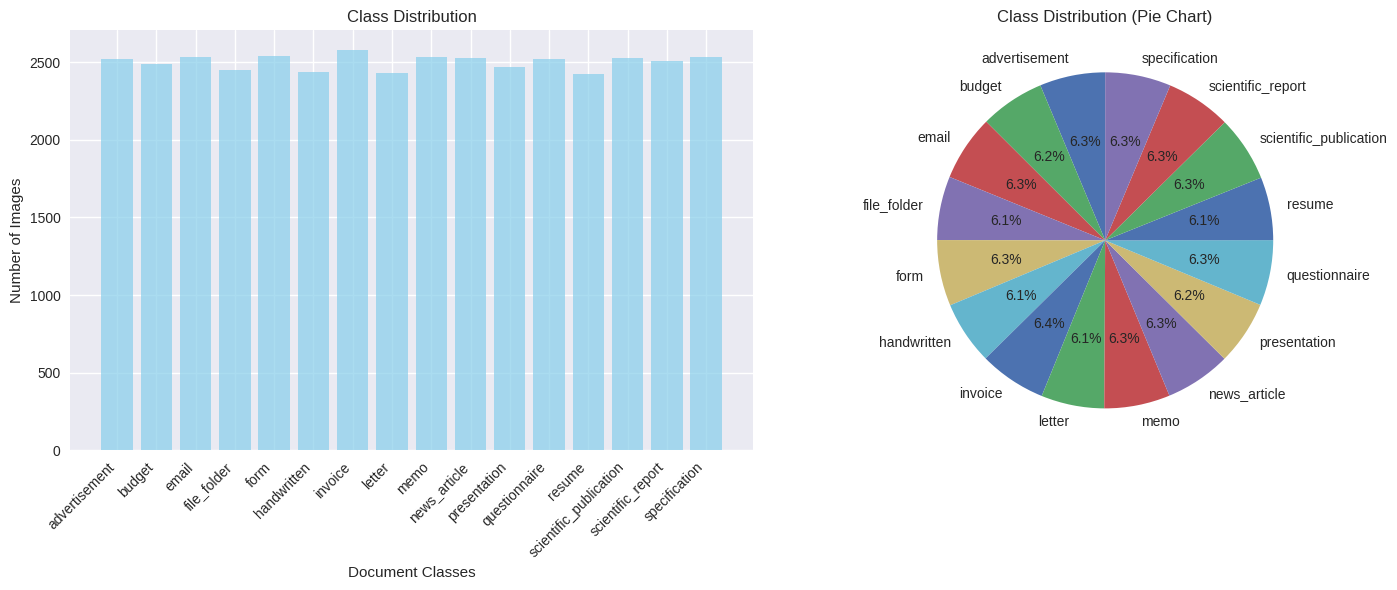


Class Distribution Summary:
                     Class  Count  Percentage
6                  invoice   2576      6.4400
4                     form   2537      6.3425
8                     memo   2533      6.3325
15           specification   2531      6.3275
2                    email   2530      6.3250
13  scientific_publication   2526      6.3150
9             news_article   2526      6.3150
0            advertisement   2522      6.3050
11           questionnaire   2517      6.2925
14       scientific_report   2508      6.2700
1                   budget   2485      6.2125
10            presentation   2468      6.1700
3              file_folder   2451      6.1275
5              handwritten   2434      6.0850
7                   letter   2430      6.0750
12                  resume   2426      6.0650


In [6]:
# Visualize class distribution
plt.figure(figsize=(15, 6))
classes = list(class_distribution.keys())
counts = list(class_distribution.values())

plt.subplot(1, 2, 1)
plt.bar(classes, counts, color='skyblue', alpha=0.7)
plt.title('Class Distribution')
plt.xlabel('Document Classes')
plt.ylabel('Number of Images')
plt.xticks(rotation=45, ha='right')

plt.subplot(1, 2, 2)
plt.pie(counts, labels=classes, autopct='%1.1f%%', startangle=90)
plt.title('Class Distribution (Pie Chart)')

plt.tight_layout()
plt.show()

# Create DataFrame for better analysis
df = pd.DataFrame({
    'Class': classes,
    'Count': counts,
    'Percentage': [count/sum(counts)*100 for count in counts]
})

print("\nClass Distribution Summary:")
print(df.sort_values('Count', ascending=False))

Sample images from each class:


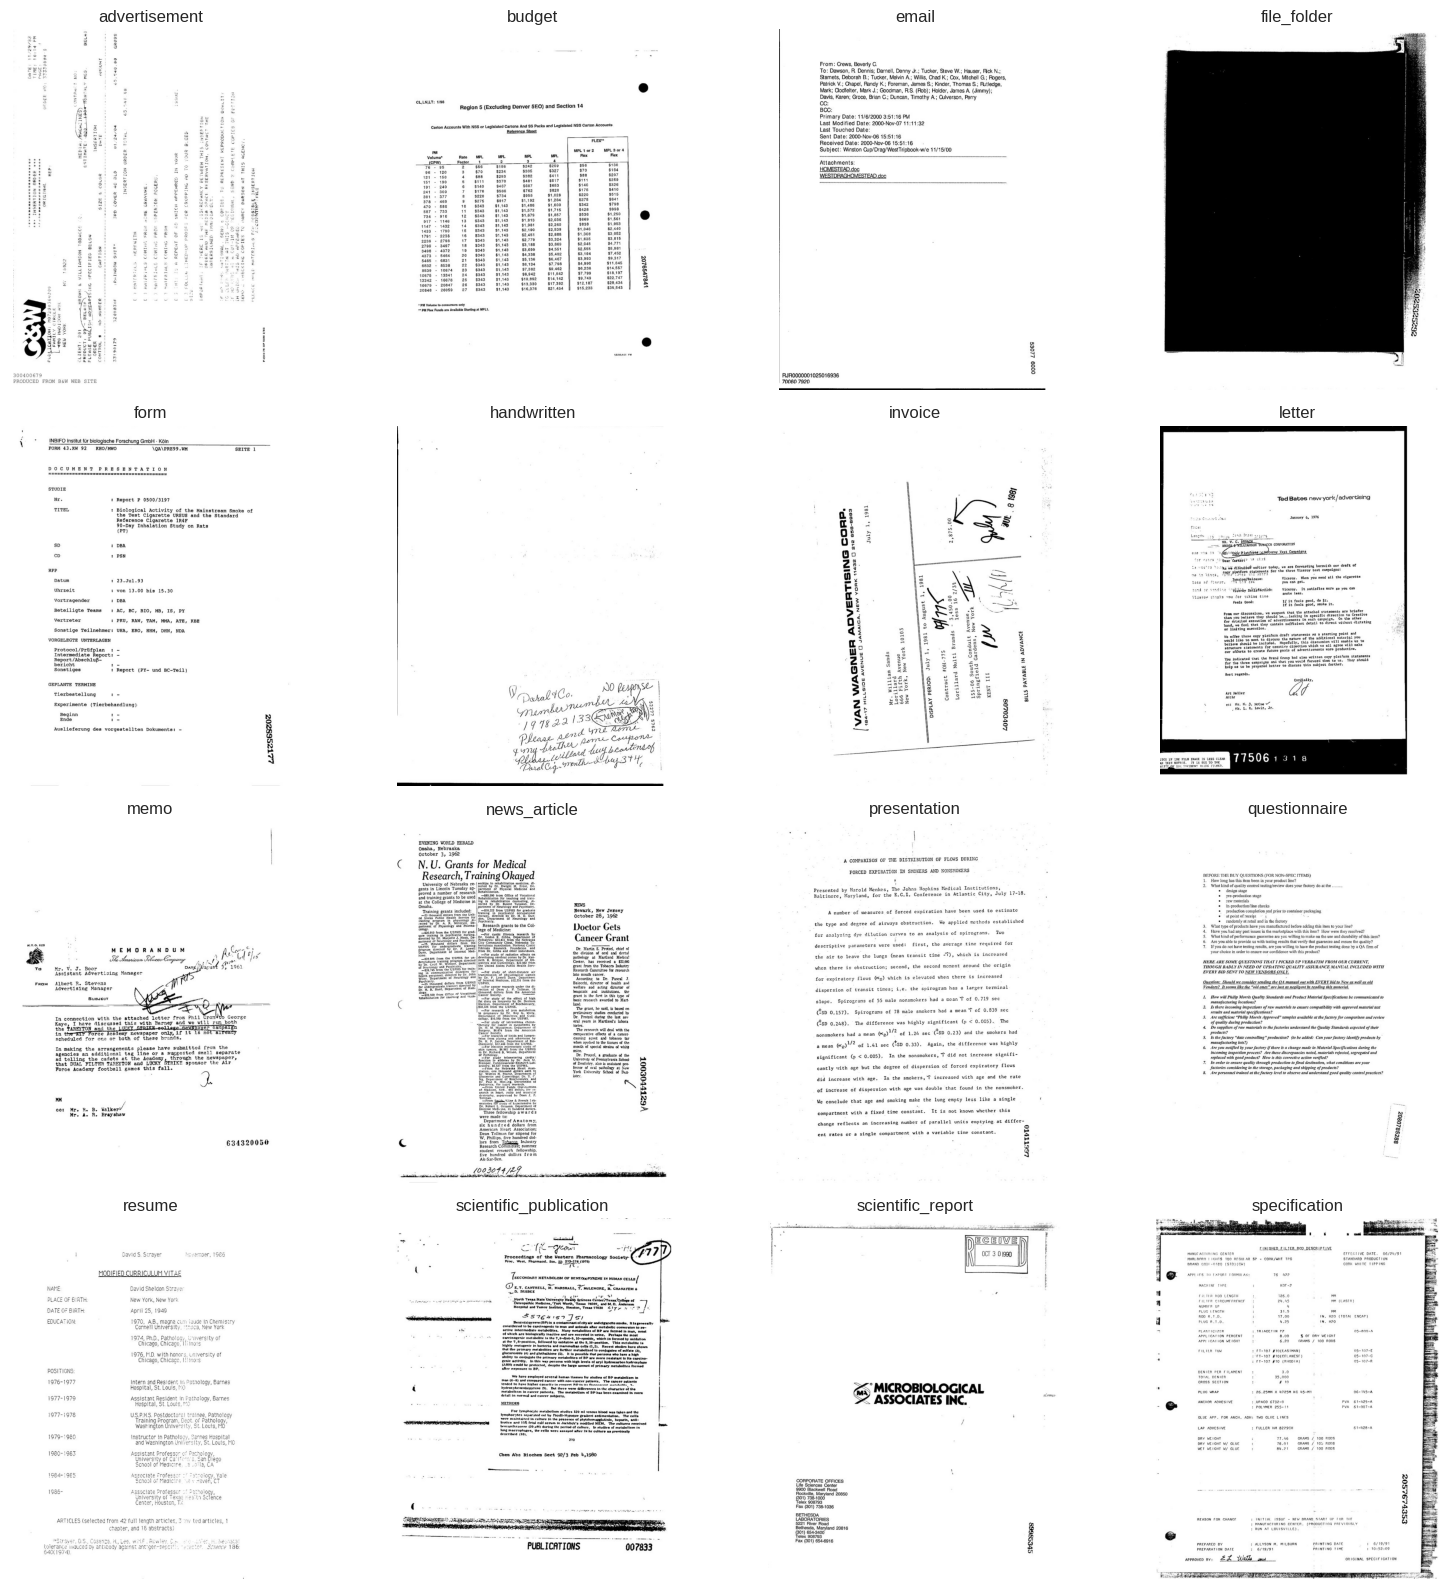

In [7]:
def visualize_samples(image_paths, labels, num_samples=16):
    """
    Visualize sample images from each class.
    """
    fig, axes = plt.subplots(4, 4, figsize=(16, 16))
    axes = axes.ravel()
    
    # Get one sample from each class
    class_samples = {}
    for img_path, label in zip(image_paths, labels):
        if label not in class_samples:
            class_samples[label] = img_path
        if len(class_samples) >= num_samples:
            break
    
    for i, (class_name, img_path) in enumerate(class_samples.items()):
        try:
            # Load and display image
            img = Image.open(img_path)
            axes[i].imshow(img, cmap='gray')
            axes[i].set_title(f'{class_name}', fontsize=12)
            axes[i].axis('off')
        except Exception as e:
            print(f"Error loading {img_path}: {e}")
            axes[i].text(0.5, 0.5, f'Error loading\n{class_name}', 
                        ha='center', va='center', transform=axes[i].transAxes)
            axes[i].axis('off')
    
    plt.tight_layout()
    plt.show()

# Visualize sample images
print("Sample images from each class:")
visualize_samples(image_paths, labels)

## 2. Data Quality Check and Preprocessing

Let's check for corrupted files and analyze image properties.

In [9]:
def check_image_quality(image_paths, labels, sample_size=1000):
    """
    Check image quality and collect statistics.
    """
    print("Checking image quality...")
    
    # Sample images for quality check
    sample_indices = np.random.choice(len(image_paths), 
                                     min(sample_size, len(image_paths)), 
                                     replace=False)
    
    valid_images = []
    valid_labels = []
    image_stats = {'widths': [], 'heights': [], 'sizes': []}
    corrupted_count = 0
    
    for idx in sample_indices:
        img_path = image_paths[idx]
        label = labels[idx]
        
        try:
            # Try to load image
            img = Image.open(img_path)
            width, height = img.size
            
            # Check if image is valid (not corrupted)
            img.verify()
            
            # Collect statistics
            image_stats['widths'].append(width)
            image_stats['heights'].append(height)
            image_stats['sizes'].append(os.path.getsize(img_path))
            
            valid_images.append(img_path)
            valid_labels.append(label)
            
        except Exception as e:
            corrupted_count += 1
            print(f"Corrupted image: {img_path}")
    
    print(f"Checked {len(sample_indices)} images")
    print(f"Valid images: {len(valid_images)}")
    print(f"Corrupted images: {corrupted_count}")
    
    # Analyze image statistics
    if image_stats['widths']:
        print(f"\nImage Statistics:")
        print(f"Width - Mean: {np.mean(image_stats['widths']):.1f}, Std: {np.std(image_stats['widths']):.1f}")
        print(f"Height - Mean: {np.mean(image_stats['heights']):.1f}, Std: {np.std(image_stats['heights']):.1f}")
        print(f"File Size - Mean: {np.mean(image_stats['sizes']):.1f} bytes, Std: {np.std(image_stats['sizes']):.1f}")
    
    return valid_images, valid_labels, image_stats

# Check image quality
valid_images, valid_labels, img_stats = check_image_quality(image_paths, labels)

Checking image quality...
Checked 1000 images
Valid images: 1000
Corrupted images: 0

Image Statistics:
Width - Mean: 766.0, Std: 21.0
Height - Mean: 1000.0, Std: 0.0
File Size - Mean: 94541.0 bytes, Std: 56358.0


In [10]:
def stratified_split(image_paths, labels, train_ratio=0.7, val_ratio=0.15, test_ratio=0.15, random_state=42):
    """
    Perform stratified split of the dataset.
    """
    print("Performing stratified split...")
    
    # Convert to numpy arrays
    image_paths = np.array(image_paths)
    labels = np.array(labels)
    
    # First split: separate train+val from test
    X_temp, X_test, y_temp, y_test = train_test_split(
        image_paths, labels, 
        test_size=test_ratio, 
        stratify=labels, 
        random_state=random_state
    )
    
    # Second split: separate train from val
    val_size = val_ratio / (train_ratio + val_ratio)
    X_train, X_val, y_train, y_val = train_test_split(
        X_temp, y_temp, 
        test_size=val_size, 
        stratify=y_temp, 
        random_state=random_state
    )
    
    print(f"Training set: {len(X_train)} images")
    print(f"Validation set: {len(X_val)} images")
    print(f"Test set: {len(X_test)} images")
    
    # Verify class distribution
    train_dist = pd.Series(y_train).value_counts().sort_index()
    val_dist = pd.Series(y_val).value_counts().sort_index()
    test_dist = pd.Series(y_test).value_counts().sort_index()
    
    print("\nClass distribution verification:")
    split_df = pd.DataFrame({
        'Train': train_dist,
        'Validation': val_dist,
        'Test': test_dist
    })
    print(split_df)
    
    return X_train, X_val, X_test, y_train, y_val, y_test

# Split the dataset
X_train, X_val, X_test, y_train, y_val, y_test = stratified_split(
    image_paths, labels, 
    CONFIG['train_ratio'], 
    CONFIG['val_ratio'], 
    CONFIG['test_ratio'], 
    CONFIG['random_state']
)

Performing stratified split...
Training set: 28000 images
Validation set: 6000 images
Test set: 6000 images

Class distribution verification:
                        Train  Validation  Test
advertisement            1766         378   378
budget                   1739         373   373
email                    1771         380   379
file_folder              1715         368   368
form                     1776         380   381
handwritten              1704         365   365
invoice                  1804         386   386
letter                   1701         365   364
memo                     1773         380   380
news_article             1768         379   379
presentation             1728         370   370
questionnaire            1762         377   378
resume                   1698         364   364
scientific_publication   1768         379   379
scientific_report        1756         376   376
specification            1771         380   380


In [9]:
def preprocess_image(img_path, target_size=(224, 224)):
    """
    Preprocess a single image for VGG16.
    """
    try:
        # Load image
        img = Image.open(img_path)
        
        # Convert to RGB if needed
        if img.mode != 'RGB':
            img = img.convert('RGB')
        
        # Resize
        img = img.resize(target_size)
        
        # Convert to numpy array
        img_array = np.array(img)
        
        # Normalize pixel values to [0, 1]
        img_array = img_array.astype(np.float32) / 255.0
        
        return img_array
    
    except Exception as e:
        print(f"Error processing {img_path}: {e}")
        # Return a black image as fallback
        return np.zeros((*target_size, 3), dtype=np.float32)

# Encode labels
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_val_encoded = label_encoder.transform(y_val)
y_test_encoded = label_encoder.transform(y_test)

# Convert to categorical
num_classes = len(label_encoder.classes_)
y_train_cat = to_categorical(y_train_encoded, num_classes)
y_val_cat = to_categorical(y_val_encoded, num_classes)
y_test_cat = to_categorical(y_test_encoded, num_classes)

print(f"Number of classes: {num_classes}")
print(f"Classes: {label_encoder.classes_}")
print(f"Train labels shape: {y_train_cat.shape}")
print(f"Validation labels shape: {y_val_cat.shape}")
print(f"Test labels shape: {y_test_cat.shape}")

# Create data generators for efficient loading
def create_data_generator(image_paths, labels, batch_size=32, shuffle=True, augment=False):
    """
    Create a data generator for batch processing.
    """
    def generator():
        indices = np.arange(len(image_paths))
        
        while True:
            if shuffle:
                np.random.shuffle(indices)
            
            for i in range(0, len(indices), batch_size):
                batch_indices = indices[i:i+batch_size]
                batch_images = []
                batch_labels = []
                
                for idx in batch_indices:
                    img = preprocess_image(image_paths[idx])
                    batch_images.append(img)
                    batch_labels.append(labels[idx])
                
                batch_images = np.array(batch_images)
                batch_labels = np.array(batch_labels)
                
                # Apply VGG16 preprocessing
                batch_images = tf.keras.applications.vgg16.preprocess_input(batch_images * 255.0)
                
                yield batch_images, batch_labels
    
    return generator

print("Data preprocessing setup complete!")

Number of classes: 16
Classes: ['advertisement' 'budget' 'email' 'file_folder' 'form' 'handwritten'
 'invoice' 'letter' 'memo' 'news_article' 'presentation' 'questionnaire'
 'resume' 'scientific_publication' 'scientific_report' 'specification']
Train labels shape: (28000, 16)
Validation labels shape: (6000, 16)
Test labels shape: (6000, 16)
Data preprocessing setup complete!


## 3. Dimensionality Reduction Analysis (PCA)

Let's analyze the feature space using PCA before training the model.

In [11]:
def perform_pca_analysis(image_paths, labels, n_samples=500, n_components=50):
    """
    Perform PCA analysis on a subset of images.
    """
    print(f"Performing PCA analysis on {n_samples} samples...")
    
    # Sample images for PCA
    sample_indices = np.random.choice(len(image_paths), 
                                     min(n_samples, len(image_paths)), 
                                     replace=False)
    
    # Load and preprocess images
    images = []
    sample_labels = []
    
    for idx in sample_indices:
        img = preprocess_image(image_paths[idx])
        images.append(img.flatten())  # Flatten for PCA
        sample_labels.append(labels[idx])
    
    images = np.array(images)
    sample_labels = np.array(sample_labels)
    
    print(f"Images shape for PCA: {images.shape}")
    
    # Standardize features
    scaler = StandardScaler()
    images_scaled = scaler.fit_transform(images)
    
    # Perform PCA
    pca = PCA(n_components=n_components)
    images_pca = pca.fit_transform(images_scaled)
    
    print(f"PCA completed. Shape after PCA: {images_pca.shape}")
    print(f"Explained variance ratio (first 10 components): {pca.explained_variance_ratio_[:10]}")
    print(f"Cumulative explained variance (first 10 components): {np.cumsum(pca.explained_variance_ratio_[:10])}")
    
    # Visualize PCA results
    plt.figure(figsize=(15, 5))
    
    # Plot explained variance
    plt.subplot(1, 3, 1)
    plt.plot(range(1, n_components + 1), pca.explained_variance_ratio_)
    plt.xlabel('Principal Component')
    plt.ylabel('Explained Variance Ratio')
    plt.title('PCA Explained Variance')
    
    # Plot cumulative explained variance
    plt.subplot(1, 3, 2)
    plt.plot(range(1, n_components + 1), np.cumsum(pca.explained_variance_ratio_))
    plt.xlabel('Principal Component')
    plt.ylabel('Cumulative Explained Variance')
    plt.title('PCA Cumulative Explained Variance')
    
    # Plot 2D PCA visualization
    plt.subplot(1, 3, 3)
    unique_labels = np.unique(sample_labels)
    colors = plt.cm.Set3(np.linspace(0, 1, len(unique_labels)))
    
    for i, label in enumerate(unique_labels):
        mask = sample_labels == label
        plt.scatter(images_pca[mask, 0], images_pca[mask, 1], 
                   c=[colors[i]], label=label, alpha=0.6, s=20)
    
    plt.xlabel('First Principal Component')
    plt.ylabel('Second Principal Component')
    plt.title('PCA 2D Visualization')
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    
    plt.tight_layout()
    plt.show()
    
    return pca, scaler, images_pca, sample_labels

# Perform PCA analysis
pca_model, scaler, pca_features, pca_labels = perform_pca_analysis(X_train, y_train)

Performing PCA analysis on 500 samples...


NameError: name 'preprocess_image' is not defined

## 4. Model Architecture

Let's build the VGG16 transfer learning model with custom classification head.

In [11]:
import tensorflow as tf
from tensorflow.keras.applications import VGG16
from tensorflow.keras import layers
from tensorflow.keras.regularizers import l2
import os

# Define input shape globally so it can be reused
input_shape = (224, 224, 3)

def create_vgg16_model(num_classes, input_shape=input_shape, 
                       dropout_rate=0.5, l2_reg=0.01):
    """
    Create VGG16 transfer learning model using Functional API.
    """
    # Load VGG16 base model
    base_model = VGG16(
        weights='imagenet',
        include_top=False,
        input_shape=input_shape
    )
    
    # Freeze base model layers
    base_model.trainable = False
    
    # Input layer
    inputs = tf.keras.Input(shape=input_shape)

    # Apply VGG16 base model
    x = base_model(inputs)
    
    # Feature extraction layers after VGG16
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.BatchNormalization()(x)
    
    x = layers.Dense(512, activation='relu', kernel_regularizer=l2(l2_reg))(x)
    x = layers.Dropout(dropout_rate)(x)
    x = layers.BatchNormalization()(x)
    
    x = layers.Dense(256, activation='relu', kernel_regularizer=l2(l2_reg))(x)
    x = layers.Dropout(dropout_rate)(x)

    x = layers.Dense(128, activation='relu', kernel_regularizer=l2(l2_reg))(x)
    x = layers.Dropout(dropout_rate / 2)(x)
    
    outputs = layers.Dense(num_classes, activation='softmax')(x)
    
    model = tf.keras.Model(inputs=inputs, outputs=outputs, name='VGG16_Custom_Architecture')
    
    return model, base_model


num_classes = 16

# Create model
model, base_model = create_vgg16_model(num_classes=num_classes)

model.summary()

# Print parameter counts
print(f"\nTotal parameters: {model.count_params():,}")
print(f"Trainable parameters: {sum([tf.size(var) for var in model.trainable_variables]):,}")
print(f"Non-trainable parameters: {sum([tf.size(var) for var in model.non_trainable_variables]):,}")

# Save model architecture plot
output_path = '../output'
os.makedirs(output_path, exist_ok=True)
tf.keras.utils.plot_model(model, to_file=os.path.join(output_path, 'vgg16_model.png'),
                          show_shapes=True, show_layer_names=True)
print(f"\nModel architecture saved as '{output_path}/vgg16_model.png'")

# Print descriptive summary
print("\nModel Architecture Details:")
print("=" * 50)
print(f"1. Input Layer: {input_shape}")
print("2. VGG16 Base Model: Feature extraction")
print("3. Global Average Pooling: Spatial dimension reduction")
print("4. Dense Layer 1: 512 units + Dropout + BatchNorm")
print("5. Dense Layer 2: 256 units + Dropout")
print("6. Dense Layer 3: 128 units + Reduced Dropout")
print(f"7. Output Layer: {num_classes} units (softmax)")
print("=" * 50)


I0000 00:00:1751795400.819656   11228 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 20386 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4090, pci bus id: 0000:01:00.0, compute capability: 8.9


Model: "VGG16_Custom_Architecture"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ vgg16 (Functional)              │ (None, 7, 7, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │       262,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 16)             │         2,064 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 15,147,728 (57.78 MB)

 Trainable params: 430,992 (1.64 MB)

 Non-trainable params: 14,716,736 (56.14 MB)


Total parameters: 15,147,728
Trainable parameters: 430,992
Non-trainable parameters: 14,716,742
You must install pydot (`pip install pydot`) for `plot_model` to work.

Model architecture saved as '../output/vgg16_model.png'

Model Architecture Details:
1. Input Layer: (224, 224, 3)
2. VGG16 Base Model: Feature extraction
3. Global Average Pooling: Spatial dimension reduction
4. Dense Layer 1: 512 units + Dropout + BatchNorm
5. Dense Layer 2: 256 units + Dropout
6. Dense Layer 3: 128 units + Reduced Dropout
7. Output Layer: 16 units (softmax)


In [12]:
# Alternative architecture: VGG16 feature extractor with custom pre and post processing
def create_advanced_vgg16_model(num_classes, input_shape=(224, 224, 3), 
                               dropout_rate=0.5, l2_reg=0.01):
    """
    Create an advanced VGG16 transfer learning model with custom feature processing.
    This architecture adds custom layers before and after VGG16 for enhanced learning.
    """
    # Load VGG16 base model (we'll use it as a feature extractor)
    base_model = VGG16(
        weights='imagenet',
        include_top=False,
        input_shape=input_shape
    )
    
    # Freeze base model layers initially
    base_model.trainable = False
    
    # Create model using Functional API with more sophisticated architecture
    inputs = tf.keras.Input(shape=input_shape)
    
    # Pre-processing layers (before VGG16)
    x = layers.Conv2D(32, (3, 3), activation='relu', padding='same', name='pre_conv1')(inputs)
    x = layers.BatchNormalization(name='pre_bn1')(x)
    x = layers.Conv2D(64, (3, 3), activation='relu', padding='same', name='pre_conv2')(x)
    x = layers.BatchNormalization(name='pre_bn2')(x)
    x = layers.MaxPooling2D((2, 2), name='pre_pool')(x)
    
    # VGG16 feature extraction (main backbone)
    vgg_features = base_model(x)
    
    # Post-processing layers (after VGG16)
    x = layers.GlobalAveragePooling2D(name='global_avg_pool')(vgg_features)
    x = layers.BatchNormalization(name='post_bn1')(x)
    
    # Feature fusion: Combine global features with additional processing
    x = layers.Dense(1024, activation='relu', kernel_regularizer=l2(l2_reg), name='dense_1024')(x)
    x = layers.Dropout(dropout_rate, name='dropout_1')(x)
    x = layers.BatchNormalization(name='post_bn2')(x)
    
    # Intermediate feature learning
    x = layers.Dense(512, activation='relu', kernel_regularizer=l2(l2_reg), name='dense_512')(x)
    x = layers.Dropout(dropout_rate, name='dropout_2')(x)
    
    # Final feature refinement
    x = layers.Dense(256, activation='relu', kernel_regularizer=l2(l2_reg), name='dense_256')(x)
    x = layers.Dropout(dropout_rate / 2, name='dropout_3')(x)
    
    # Classification head
    outputs = layers.Dense(num_classes, activation='softmax', name='classification_output')(x)
    
    # Create the model
    model = tf.keras.Model(inputs=inputs, outputs=outputs, name='Advanced_VGG16_Architecture')
    
    return model, base_model

# Uncomment the line below to use the advanced architecture instead
# model, base_model = create_advanced_vgg16_model(num_classes)

print("Alternative advanced architecture function created!")
print("To use the advanced architecture, uncomment the line above and re-run the cell.")
print("The advanced architecture includes:")
print("- Custom pre-processing layers before VGG16")
print("- VGG16 as the main feature extractor")
print("- Enhanced post-processing with multiple dense layers")
print("- Improved feature fusion and refinement")

Alternative advanced architecture function created!
To use the advanced architecture, uncomment the line above and re-run the cell.
The advanced architecture includes:
- Custom pre-processing layers before VGG16
- VGG16 as the main feature extractor
- Enhanced post-processing with multiple dense layers
- Improved feature fusion and refinement


In [13]:
# Compile the model
model.compile(
    optimizer=optimizers.Adam(learning_rate=1e-5),
    loss='categorical_crossentropy',
    metrics=['accuracy', tf.keras.metrics.TopKCategoricalAccuracy(k=3, name='top_3_accuracy')]
)

# Setup callbacks
callbacks_list = [
    callbacks.EarlyStopping(
        monitor='val_loss',
        patience=10,
        restore_best_weights=True,
        verbose=1
    ),
    callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=5,
        min_lr=1e-7,
        verbose=1
    ),
    callbacks.ModelCheckpoint(
        filepath='./output/best_vgg16_model.h5',
        monitor='val_accuracy',
        save_best_only=True,
        verbose=1
    ),
    callbacks.CSVLogger('./output/training_log.csv'),
    callbacks.TensorBoard(log_dir='./output/logs', histogram_freq=1)
]

print("Training setup complete!")
print("Callbacks configured:")
for callback in callbacks_list:
    print(f"  - {callback.__class__.__name__}")

# Create data generators
train_generator = create_data_generator(X_train, y_train_cat, CONFIG['batch_size'], shuffle=True)
val_generator = create_data_generator(X_val, y_val_cat, CONFIG['batch_size'], shuffle=False)

# Calculate steps per epoch
steps_per_epoch = len(X_train) // CONFIG['batch_size']
validation_steps = len(X_val) // CONFIG['batch_size']

print(f"\nSteps per epoch: {steps_per_epoch}")
print(f"Validation steps: {validation_steps}")

Training setup complete!
Callbacks configured:
  - EarlyStopping
  - ReduceLROnPlateau
  - ModelCheckpoint
  - CSVLogger
  - TensorBoard

Steps per epoch: 875
Validation steps: 187


## 5. Training

Let's train the model in two phases: first with frozen base layers, then with fine-tuning.

PHASE 1: Training with frozen VGG16 base layers
Training for 20 epochs...
Epoch 1/20


I0000 00:00:1751795402.559831   11379 service.cc:152] XLA service 0x7e2e38015340 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1751795402.559846   11379 service.cc:160]   StreamExecutor device (0): NVIDIA GeForce RTX 4090, Compute Capability 8.9
2025-07-06 15:35:02.591676: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1751795402.812016   11379 cuda_dnn.cc:529] Loaded cuDNN version 91002


  1/875 ━━━━━━━━━━━━━━━━━━━━ 1:05:22 4s/step - accuracy: 0.0312 - loss: 13.9838 - top_3_accuracy: 0.1250

I0000 00:00:1751795405.946516   11379 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


875/875 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step - accuracy: 0.3192 - loss: 7.8820 - top_3_accuracy: 0.5402

2025-07-06 15:37:39.092304: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_359', 4 bytes spill stores, 4 bytes spill loads




Epoch 1: val_accuracy improved from -inf to 0.53459, saving model to ./output/best_vgg16_model.h5


875/875 ━━━━━━━━━━━━━━━━━━━━ 191s 214ms/step - accuracy: 0.3193 - loss: 7.8789 - top_3_accuracy: 0.5403 - val_accuracy: 0.5346 - val_loss: 2.4397 - val_top_3_accuracy: 0.7609 - learning_rate: 0.0010
Epoch 2/20
875/875 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step - accuracy: 0.4983 - loss: 2.4502 - top_3_accuracy: 0.7345
Epoch 2: val_accuracy improved from 0.53459 to 0.54529, saving model to ./output/best_vgg16_model.h5


875/875 ━━━━━━━━━━━━━━━━━━━━ 185s 212ms/step - accuracy: 0.4984 - loss: 2.4501 - top_3_accuracy: 0.7345 - val_accuracy: 0.5453 - val_loss: 2.2967 - val_top_3_accuracy: 0.7674 - learning_rate: 0.0010
Epoch 3/20
875/875 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step - accuracy: 0.5037 - loss: 2.4106 - top_3_accuracy: 0.7344
Epoch 3: val_accuracy did not improve from 0.54529
875/875 ━━━━━━━━━━━━━━━━━━━━ 184s 211ms/step - accuracy: 0.5037 - loss: 2.4106 - top_3_accuracy: 0.7344 - val_accuracy: 0.5393 - val_loss: 2.3132 - val_top_3_accuracy: 0.7672 - learning_rate: 0.0010
Epoch 4/20
875/875 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step - accuracy: 0.5080 - loss: 2.4168 - top_3_accuracy: 0.7395
Epoch 4: val_accuracy improved from 0.54529 to 0.54813, saving model to ./output/best_vgg16_model.h5


875/875 ━━━━━━━━━━━━━━━━━━━━ 184s 211ms/step - accuracy: 0.5080 - loss: 2.4168 - top_3_accuracy: 0.7395 - val_accuracy: 0.5481 - val_loss: 2.3482 - val_top_3_accuracy: 0.7761 - learning_rate: 0.0010
Epoch 5/20
875/875 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step - accuracy: 0.5128 - loss: 2.4421 - top_3_accuracy: 0.7420
Epoch 5: val_accuracy did not improve from 0.54813
875/875 ━━━━━━━━━━━━━━━━━━━━ 183s 210ms/step - accuracy: 0.5128 - loss: 2.4421 - top_3_accuracy: 0.7420 - val_accuracy: 0.5480 - val_loss: 2.3392 - val_top_3_accuracy: 0.7737 - learning_rate: 0.0010
Epoch 6/20
875/875 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step - accuracy: 0.5127 - loss: 2.4212 - top_3_accuracy: 0.7435
Epoch 6: val_accuracy did not improve from 0.54813
875/875 ━━━━━━━━━━━━━━━━━━━━ 180s 206ms/step - accuracy: 0.5127 - loss: 2.4212 - top_3_accuracy: 0.7435 - val_accuracy: 0.5423 - val_loss: 2.3680 - val_top_3_accuracy: 0.7697 - learning_rate: 0.0010
Epoch 7/20
875/875 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step - accuracy: 0.5143 - 

875/875 ━━━━━━━━━━━━━━━━━━━━ 164s 187ms/step - accuracy: 0.5357 - loss: 2.2057 - top_3_accuracy: 0.7586 - val_accuracy: 0.5852 - val_loss: 1.9453 - val_top_3_accuracy: 0.7956 - learning_rate: 5.0000e-04
Epoch 9/20
875/875 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step - accuracy: 0.5652 - loss: 1.9889 - top_3_accuracy: 0.7810
Epoch 9: val_accuracy did not improve from 0.58523
875/875 ━━━━━━━━━━━━━━━━━━━━ 153s 175ms/step - accuracy: 0.5652 - loss: 1.9889 - top_3_accuracy: 0.7810 - val_accuracy: 0.5797 - val_loss: 1.9316 - val_top_3_accuracy: 0.8033 - learning_rate: 5.0000e-04
Epoch 10/20
875/875 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step - accuracy: 0.5554 - loss: 1.9987 - top_3_accuracy: 0.7731
Epoch 10: val_accuracy improved from 0.58523 to 0.58890, saving model to ./output/best_vgg16_model.h5


875/875 ━━━━━━━━━━━━━━━━━━━━ 153s 175ms/step - accuracy: 0.5554 - loss: 1.9987 - top_3_accuracy: 0.7731 - val_accuracy: 0.5889 - val_loss: 1.8826 - val_top_3_accuracy: 0.8092 - learning_rate: 5.0000e-04
Epoch 11/20
875/875 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step - accuracy: 0.5639 - loss: 1.9703 - top_3_accuracy: 0.7857
Epoch 11: val_accuracy improved from 0.58890 to 0.60495, saving model to ./output/best_vgg16_model.h5


875/875 ━━━━━━━━━━━━━━━━━━━━ 153s 175ms/step - accuracy: 0.5639 - loss: 1.9703 - top_3_accuracy: 0.7857 - val_accuracy: 0.6049 - val_loss: 1.8584 - val_top_3_accuracy: 0.8143 - learning_rate: 5.0000e-04
Epoch 12/20
875/875 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step - accuracy: 0.5696 - loss: 1.9435 - top_3_accuracy: 0.7842
Epoch 12: val_accuracy did not improve from 0.60495
875/875 ━━━━━━━━━━━━━━━━━━━━ 153s 175ms/step - accuracy: 0.5695 - loss: 1.9435 - top_3_accuracy: 0.7842 - val_accuracy: 0.5877 - val_loss: 1.8879 - val_top_3_accuracy: 0.8058 - learning_rate: 5.0000e-04
Epoch 13/20
875/875 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step - accuracy: 0.5628 - loss: 1.9617 - top_3_accuracy: 0.7838
Epoch 13: val_accuracy improved from 0.60495 to 0.60745, saving model to ./output/best_vgg16_model.h5


875/875 ━━━━━━━━━━━━━━━━━━━━ 153s 175ms/step - accuracy: 0.5628 - loss: 1.9617 - top_3_accuracy: 0.7838 - val_accuracy: 0.6075 - val_loss: 1.8609 - val_top_3_accuracy: 0.8217 - learning_rate: 5.0000e-04
Epoch 14/20
875/875 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step - accuracy: 0.5644 - loss: 1.9688 - top_3_accuracy: 0.7818
Epoch 14: val_accuracy did not improve from 0.60745
875/875 ━━━━━━━━━━━━━━━━━━━━ 153s 175ms/step - accuracy: 0.5644 - loss: 1.9688 - top_3_accuracy: 0.7818 - val_accuracy: 0.6031 - val_loss: 1.8707 - val_top_3_accuracy: 0.8080 - learning_rate: 5.0000e-04
Epoch 15/20
875/875 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step - accuracy: 0.5656 - loss: 1.9487 - top_3_accuracy: 0.7842
Epoch 15: val_accuracy did not improve from 0.60745
875/875 ━━━━━━━━━━━━━━━━━━━━ 153s 176ms/step - accuracy: 0.5656 - loss: 1.9487 - top_3_accuracy: 0.7842 - val_accuracy: 0.5943 - val_loss: 1.8837 - val_top_3_accuracy: 0.8158 - learning_rate: 5.0000e-04
Epoch 16/20
875/875 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step - ac

875/875 ━━━━━━━━━━━━━━━━━━━━ 153s 175ms/step - accuracy: 0.5931 - loss: 1.8463 - top_3_accuracy: 0.8022 - val_accuracy: 0.6145 - val_loss: 1.7079 - val_top_3_accuracy: 0.8219 - learning_rate: 2.5000e-04
Epoch 18/20
875/875 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step - accuracy: 0.5996 - loss: 1.7321 - top_3_accuracy: 0.8101
Epoch 18: val_accuracy improved from 0.61447 to 0.62483, saving model to ./output/best_vgg16_model.h5


875/875 ━━━━━━━━━━━━━━━━━━━━ 153s 175ms/step - accuracy: 0.5996 - loss: 1.7321 - top_3_accuracy: 0.8101 - val_accuracy: 0.6248 - val_loss: 1.6610 - val_top_3_accuracy: 0.8275 - learning_rate: 2.5000e-04
Epoch 19/20
875/875 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step - accuracy: 0.6023 - loss: 1.6920 - top_3_accuracy: 0.8179
Epoch 19: val_accuracy improved from 0.62483 to 0.62650, saving model to ./output/best_vgg16_model.h5


875/875 ━━━━━━━━━━━━━━━━━━━━ 153s 175ms/step - accuracy: 0.6023 - loss: 1.6920 - top_3_accuracy: 0.8179 - val_accuracy: 0.6265 - val_loss: 1.6446 - val_top_3_accuracy: 0.8272 - learning_rate: 2.5000e-04
Epoch 20/20
875/875 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step - accuracy: 0.6114 - loss: 1.6706 - top_3_accuracy: 0.8153
Epoch 20: val_accuracy improved from 0.62650 to 0.63653, saving model to ./output/best_vgg16_model.h5


875/875 ━━━━━━━━━━━━━━━━━━━━ 153s 175ms/step - accuracy: 0.6114 - loss: 1.6706 - top_3_accuracy: 0.8153 - val_accuracy: 0.6365 - val_loss: 1.6134 - val_top_3_accuracy: 0.8307 - learning_rate: 2.5000e-04
Restoring model weights from the end of the best epoch: 20.
Phase 1 training completed!


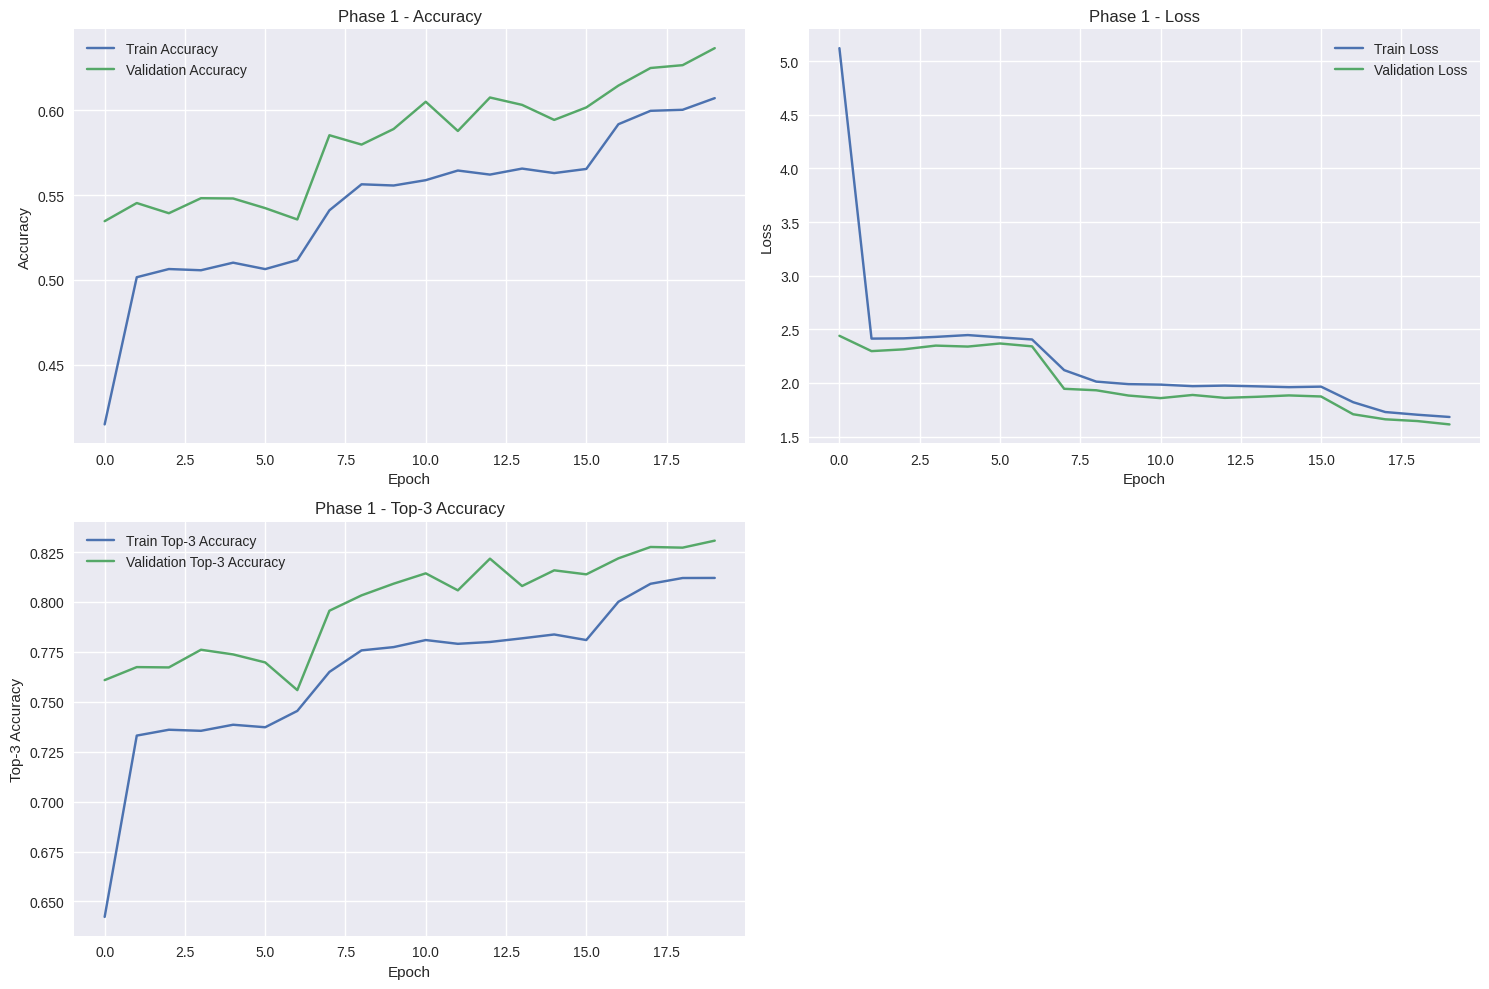

In [14]:
# Phase 1: Train with frozen base layers
print("=" * 50)
print("PHASE 1: Training with frozen VGG16 base layers")
print("=" * 50)

# Create dataset objects for better performance
train_dataset = tf.data.Dataset.from_generator(
    train_generator,
    output_signature=(
        tf.TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32),
        tf.TensorSpec(shape=(None, num_classes), dtype=tf.float32)
    )
).prefetch(tf.data.AUTOTUNE)

val_dataset = tf.data.Dataset.from_generator(
    val_generator,
    output_signature=(
        tf.TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32),
        tf.TensorSpec(shape=(None, num_classes), dtype=tf.float32)
    )
).prefetch(tf.data.AUTOTUNE)

# Train Phase 1
phase1_epochs = 20
print(f"Training for {phase1_epochs} epochs...")

history_phase1 = model.fit(
    train_dataset,
    epochs=phase1_epochs,
    steps_per_epoch=steps_per_epoch,
    validation_data=val_dataset,
    validation_steps=validation_steps,
    callbacks=callbacks_list,
    verbose=1
)

print("Phase 1 training completed!")

# Plot Phase 1 training history
def plot_training_history(history, phase_name):
    """Plot training history."""
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    
    # Accuracy
    axes[0, 0].plot(history.history['accuracy'], label='Train Accuracy')
    axes[0, 0].plot(history.history['val_accuracy'], label='Validation Accuracy')
    axes[0, 0].set_title(f'{phase_name} - Accuracy')
    axes[0, 0].set_xlabel('Epoch')
    axes[0, 0].set_ylabel('Accuracy')
    axes[0, 0].legend()
    axes[0, 0].grid(True)
    
    # Loss
    axes[0, 1].plot(history.history['loss'], label='Train Loss')
    axes[0, 1].plot(history.history['val_loss'], label='Validation Loss')
    axes[0, 1].set_title(f'{phase_name} - Loss')
    axes[0, 1].set_xlabel('Epoch')
    axes[0, 1].set_ylabel('Loss')
    axes[0, 1].legend()
    axes[0, 1].grid(True)
    
    # Top-3 Accuracy
    axes[1, 0].plot(history.history['top_3_accuracy'], label='Train Top-3 Accuracy')
    axes[1, 0].plot(history.history['val_top_3_accuracy'], label='Validation Top-3 Accuracy')
    axes[1, 0].set_title(f'{phase_name} - Top-3 Accuracy')
    axes[1, 0].set_xlabel('Epoch')
    axes[1, 0].set_ylabel('Top-3 Accuracy')
    axes[1, 0].legend()
    axes[1, 0].grid(True)
    
    # Learning Rate
    if 'lr' in history.history:
        axes[1, 1].plot(history.history['lr'], label='Learning Rate')
        axes[1, 1].set_title(f'{phase_name} - Learning Rate')
        axes[1, 1].set_xlabel('Epoch')
        axes[1, 1].set_ylabel('Learning Rate')
        axes[1, 1].set_yscale('log')
        axes[1, 1].legend()
        axes[1, 1].grid(True)
    else:
        axes[1, 1].axis('off')
    
    plt.tight_layout()
    plt.show()

plot_training_history(history_phase1, "Phase 1")

PHASE 2: Fine-tuning with unfrozen top VGG16 layers
Total layers in base model: 19
Trainable layers: 4

Trainable parameters after unfreezing: 7,510,416
Non-trainable parameters: 7,637,318
Fine-tuning for 15 epochs...
Epoch 1/15
875/875 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step - accuracy: 0.9915 - loss: 0.1967 - top_3_accuracy: 0.9985
Epoch 1: val_accuracy improved from -inf to 0.83406, saving model to best_vgg16_finetuned.h5


875/875 ━━━━━━━━━━━━━━━━━━━━ 188s 212ms/step - accuracy: 0.9915 - loss: 0.1967 - top_3_accuracy: 0.9985 - val_accuracy: 0.8341 - val_loss: 0.8101 - val_top_3_accuracy: 0.9323 - learning_rate: 1.0000e-05
Epoch 2/15
875/875 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step - accuracy: 0.9949 - loss: 0.1830 - top_3_accuracy: 0.9992
Epoch 2: val_accuracy improved from 0.83406 to 0.83590, saving model to best_vgg16_finetuned.h5


875/875 ━━━━━━━━━━━━━━━━━━━━ 184s 211ms/step - accuracy: 0.9949 - loss: 0.1830 - top_3_accuracy: 0.9992 - val_accuracy: 0.8359 - val_loss: 0.7980 - val_top_3_accuracy: 0.9328 - learning_rate: 1.0000e-05
Epoch 3/15
875/875 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step - accuracy: 0.9955 - loss: 0.1726 - top_3_accuracy: 0.9995
Epoch 3: val_accuracy did not improve from 0.83590
875/875 ━━━━━━━━━━━━━━━━━━━━ 184s 211ms/step - accuracy: 0.9955 - loss: 0.1726 - top_3_accuracy: 0.9995 - val_accuracy: 0.8352 - val_loss: 0.7962 - val_top_3_accuracy: 0.9295 - learning_rate: 1.0000e-05
Epoch 4/15
875/875 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step - accuracy: 0.9964 - loss: 0.1647 - top_3_accuracy: 0.9997
Epoch 4: val_accuracy improved from 0.83590 to 0.83773, saving model to best_vgg16_finetuned.h5


875/875 ━━━━━━━━━━━━━━━━━━━━ 183s 210ms/step - accuracy: 0.9964 - loss: 0.1647 - top_3_accuracy: 0.9997 - val_accuracy: 0.8377 - val_loss: 0.7960 - val_top_3_accuracy: 0.9308 - learning_rate: 1.0000e-05
Epoch 5/15
875/875 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step - accuracy: 0.9970 - loss: 0.1583 - top_3_accuracy: 0.9996
Epoch 5: val_accuracy improved from 0.83773 to 0.83807, saving model to best_vgg16_finetuned.h5


875/875 ━━━━━━━━━━━━━━━━━━━━ 182s 209ms/step - accuracy: 0.9970 - loss: 0.1583 - top_3_accuracy: 0.9996 - val_accuracy: 0.8381 - val_loss: 0.7908 - val_top_3_accuracy: 0.9300 - learning_rate: 1.0000e-05
Epoch 6/15
875/875 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step - accuracy: 0.9969 - loss: 0.1519 - top_3_accuracy: 0.9997
Epoch 6: val_accuracy did not improve from 0.83807
875/875 ━━━━━━━━━━━━━━━━━━━━ 179s 205ms/step - accuracy: 0.9969 - loss: 0.1519 - top_3_accuracy: 0.9997 - val_accuracy: 0.8377 - val_loss: 0.7897 - val_top_3_accuracy: 0.9303 - learning_rate: 1.0000e-05
Epoch 7/15
875/875 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step - accuracy: 0.9976 - loss: 0.1469 - top_3_accuracy: 0.9994
Epoch 7: val_accuracy did not improve from 0.83807
875/875 ━━━━━━━━━━━━━━━━━━━━ 174s 199ms/step - accuracy: 0.9976 - loss: 0.1469 - top_3_accuracy: 0.9994 - val_accuracy: 0.8377 - val_loss: 0.7838 - val_top_3_accuracy: 0.9303 - learning_rate: 1.0000e-05
Epoch 8/15
875/875 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step - accurac

875/875 ━━━━━━━━━━━━━━━━━━━━ 153s 175ms/step - accuracy: 0.9981 - loss: 0.1325 - top_3_accuracy: 0.9996 - val_accuracy: 0.8389 - val_loss: 0.7723 - val_top_3_accuracy: 0.9313 - learning_rate: 1.0000e-05
Epoch 11/15
875/875 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step - accuracy: 0.9980 - loss: 0.1288 - top_3_accuracy: 0.9997
Epoch 11: val_accuracy did not improve from 0.83890
875/875 ━━━━━━━━━━━━━━━━━━━━ 153s 175ms/step - accuracy: 0.9980 - loss: 0.1288 - top_3_accuracy: 0.9997 - val_accuracy: 0.8367 - val_loss: 0.7777 - val_top_3_accuracy: 0.9318 - learning_rate: 1.0000e-05
Epoch 12/15
875/875 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step - accuracy: 0.9986 - loss: 0.1236 - top_3_accuracy: 0.9994
Epoch 12: val_accuracy did not improve from 0.83890
875/875 ━━━━━━━━━━━━━━━━━━━━ 153s 175ms/step - accuracy: 0.9986 - loss: 0.1236 - top_3_accuracy: 0.9994 - val_accuracy: 0.8386 - val_loss: 0.7621 - val_top_3_accuracy: 0.9313 - learning_rate: 1.0000e-05
Epoch 13/15
875/875 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step - ac

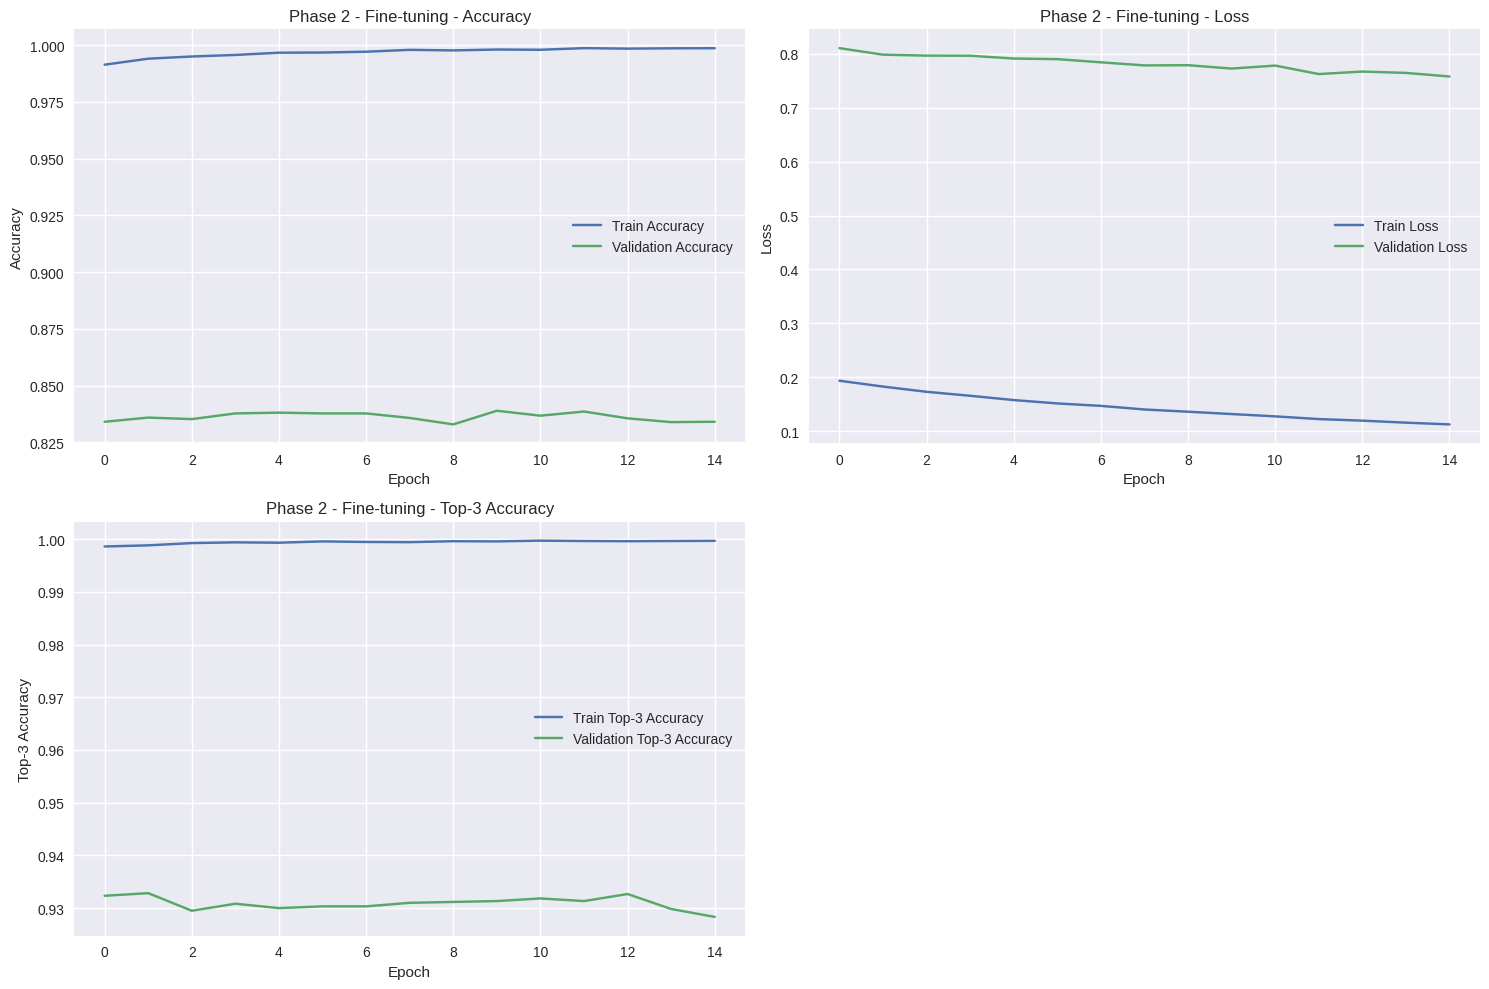

In [21]:
print("=" * 50)
print("PHASE 2: Fine-tuning with unfrozen top VGG16 layers")
print("=" * 50)

# Unfreeze the top convolutional block (block5)
set_trainable = False
for layer in base_model.layers:
    if layer.name.startswith("block5"):
        set_trainable = True
    layer.trainable = set_trainable

# Sanity check
print(f"Total layers in base model: {len(base_model.layers)}")
print(f"Trainable layers: {sum([layer.trainable for layer in base_model.layers])}")

# Recompile with lower learning rate
model.compile(
    optimizer=optimizers.Adam(learning_rate=1e-5),  # Safer LR for fine-tuning
    loss='categorical_crossentropy',
    metrics=['accuracy', tf.keras.metrics.TopKCategoricalAccuracy(k=3, name='top_3_accuracy')]
)

print(f"\nTrainable parameters after unfreezing: {sum([tf.size(var) for var in model.trainable_variables]):,}")
print(f"Non-trainable parameters: {sum([tf.size(var) for var in model.non_trainable_variables]):,}")

# Callbacks
callbacks_phase2 = [
    callbacks.EarlyStopping(
        monitor='val_loss',
        patience=8,
        restore_best_weights=True,
        verbose=1
    ),
    callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.3,
        patience=4,
        min_lr=1e-8,
        verbose=1
    ),
    callbacks.ModelCheckpoint(
        filepath='best_vgg16_finetuned.h5',  # Simplified path
        monitor='val_accuracy',
        save_best_only=True,
        verbose=1
    )
]

# Train Phase 2
phase2_epochs = 15
print(f"Fine-tuning for {phase2_epochs} epochs...")

history_phase2 = model.fit(
    train_dataset,
    epochs=phase2_epochs,
    steps_per_epoch=steps_per_epoch,
    validation_data=val_dataset,
    validation_steps=validation_steps,
    callbacks=callbacks_phase2,
    verbose=1
)

print("Phase 2 fine-tuning completed!")

# Plot history
plot_training_history(history_phase2, "Phase 2 - Fine-tuning")


## 6. Model Evaluation

Let's evaluate the trained model on the test set and analyze the results.

In [22]:
# Create test data generator
test_generator = create_data_generator(X_test, y_test_cat, CONFIG['batch_size'], shuffle=False)
test_steps = len(X_test) // CONFIG['batch_size']

test_dataset = tf.data.Dataset.from_generator(
    test_generator,
    output_signature=(
        tf.TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32),
        tf.TensorSpec(shape=(None, num_classes), dtype=tf.float32)
    )
).prefetch(tf.data.AUTOTUNE)

# Evaluate on test set
print("Evaluating model on test set...")
test_results = model.evaluate(test_dataset, steps=test_steps, verbose=1)

print(f"\\nTest Results:")
print(f"Test Loss: {test_results[0]:.4f}")
print(f"Test Accuracy: {test_results[1]:.4f}")
print(f"Test Top-3 Accuracy: {test_results[2]:.4f}")

# Generate predictions for detailed analysis
print("\\nGenerating predictions for detailed analysis...")
y_pred_probs = model.predict(test_dataset, steps=test_steps, verbose=1)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = np.argmax(y_test_cat[:len(y_pred)], axis=1)

print(f"Predictions shape: {y_pred.shape}")
print(f"True labels shape: {y_true.shape}")

# Calculate additional metrics
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred, average='weighted')
recall = recall_score(y_true, y_pred, average='weighted')
f1 = f1_score(y_true, y_pred, average='weighted')

print(f"\\nDetailed Test Metrics:")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision (weighted): {precision:.4f}")
print(f"Recall (weighted): {recall:.4f}")
print(f"F1-score (weighted): {f1:.4f}")

Evaluating model on test set...
187/187 ━━━━━━━━━━━━━━━━━━━━ 33s 178ms/step - accuracy: 0.8350 - loss: 0.7215 - top_3_accuracy: 0.9327
\nTest Results:
Test Loss: 0.7366
Test Accuracy: 0.8394
Test Top-3 Accuracy: 0.9328
\nGenerating predictions for detailed analysis...
187/187 ━━━━━━━━━━━━━━━━━━━━ 33s 176ms/step
Predictions shape: (5984,)
True labels shape: (5984,)
\nDetailed Test Metrics:
Accuracy: 0.8394
Precision (weighted): 0.8432
Recall (weighted): 0.8394
F1-score (weighted): 0.8407


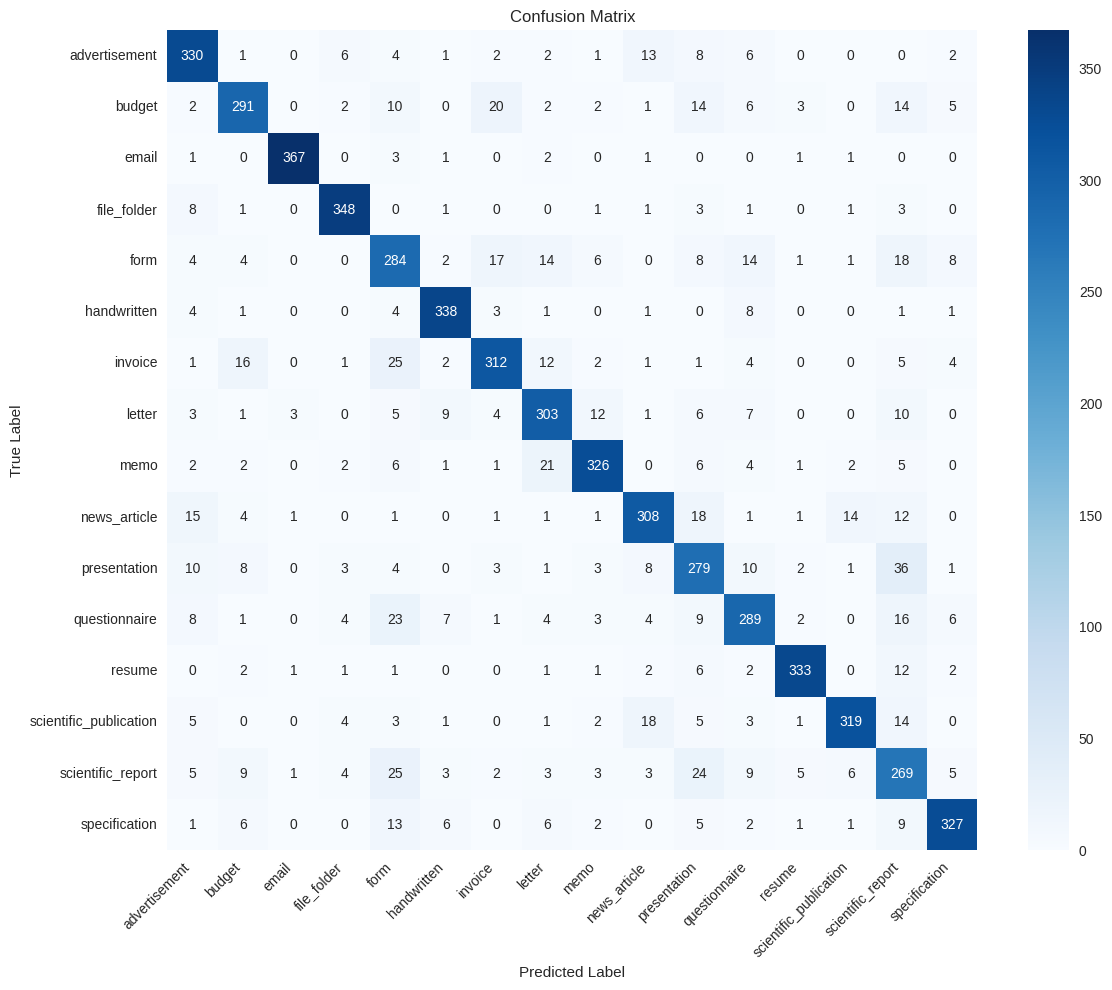

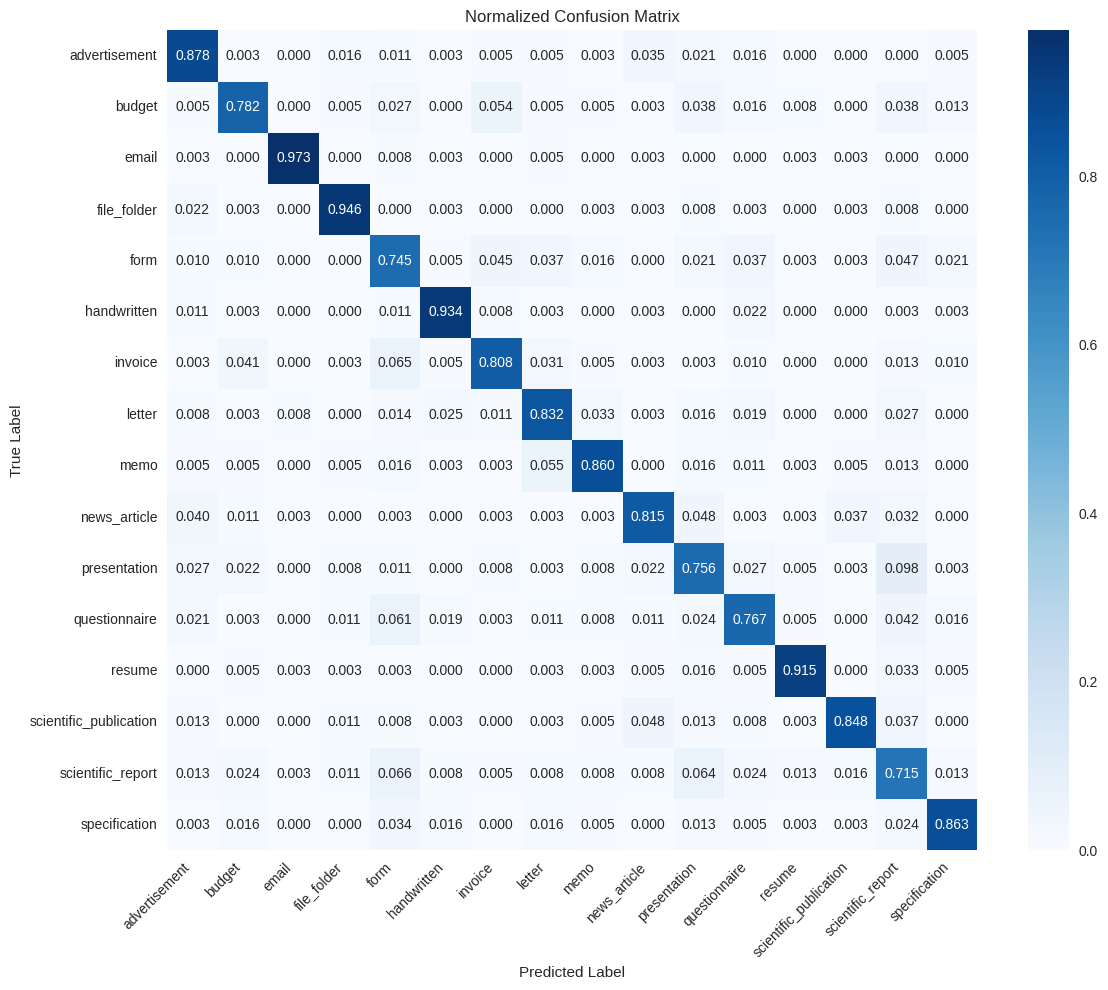


Classification Report:
                        precision    recall  f1-score   support

         advertisement       0.83      0.88      0.85       376
                budget       0.84      0.78      0.81       372
                 email       0.98      0.97      0.98       377
           file_folder       0.93      0.95      0.94       368
                  form       0.69      0.75      0.72       381
           handwritten       0.91      0.93      0.92       362
               invoice       0.85      0.81      0.83       386
                letter       0.81      0.83      0.82       364
                  memo       0.89      0.86      0.88       379
          news_article       0.85      0.81      0.83       378
          presentation       0.71      0.76      0.73       369
         questionnaire       0.79      0.77      0.78       377
                resume       0.95      0.91      0.93       364
scientific_publication       0.92      0.85      0.88       376
     scientific

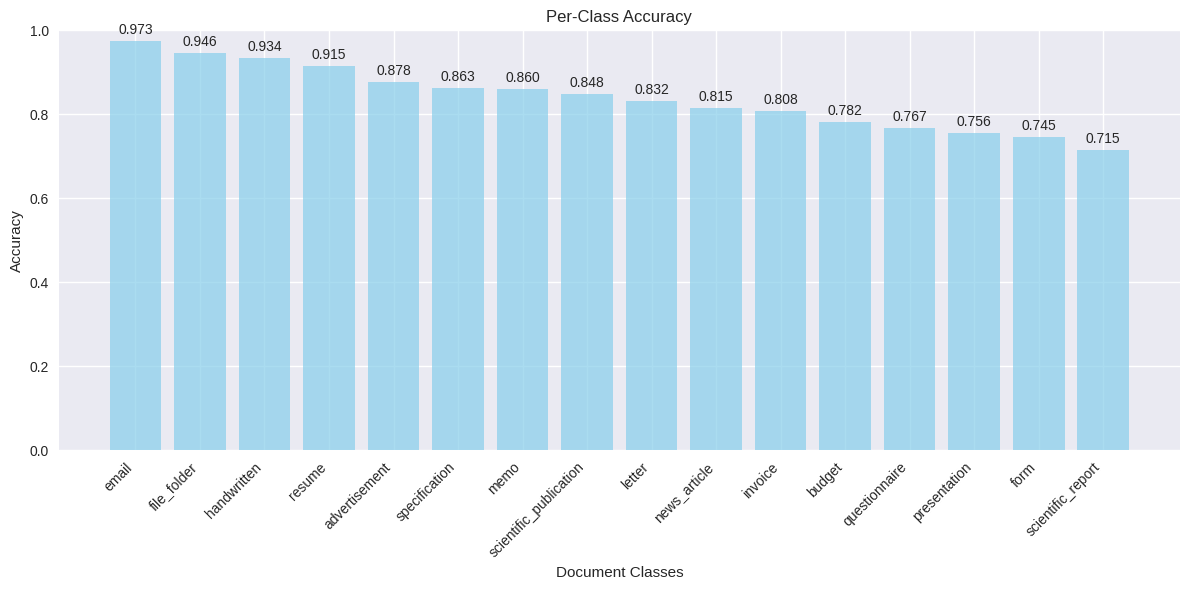

In [23]:
# Generate confusion matrix
cm = confusion_matrix(y_true, y_pred)
class_names = label_encoder.classes_

# Plot confusion matrix
plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.savefig('./output/confusion_matrix.png', dpi=150, bbox_inches='tight')
plt.show()

# Plot normalized confusion matrix
plt.figure(figsize=(12, 10))
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
sns.heatmap(cm_normalized, annot=True, fmt='.3f', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.title('Normalized Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.savefig('./output/normalized_confusion_matrix.png', dpi=150, bbox_inches='tight')
plt.show()

# Classification report
print("\nClassification Report:")
print("=" * 60)
report = classification_report(y_true, y_pred, target_names=class_names)
print(report)

# Save classification report
with open('./output/classification_report.txt', 'w') as f:
    f.write("Classification Report\n")
    f.write("=" * 60 + "\n")
    f.write(report)
print("Classification report saved to: ./output/classification_report.txt")

# Per-class accuracy
class_accuracies = cm.diagonal() / cm.sum(axis=1)
accuracy_df = pd.DataFrame({
    'Class': class_names,
    'Accuracy': class_accuracies,
    'Support': cm.sum(axis=1)
}).sort_values('Accuracy', ascending=False)

print("\nPer-Class Accuracy:")
print(accuracy_df)

# Save per-class accuracy
accuracy_df.to_csv('./output/per_class_accuracy.csv', index=False)
print("Per-class accuracy saved to: ./output/per_class_accuracy.csv")

# Plot per-class accuracy
plt.figure(figsize=(12, 6))
plt.bar(accuracy_df['Class'], accuracy_df['Accuracy'], color='skyblue', alpha=0.7)
plt.title('Per-Class Accuracy')
plt.xlabel('Document Classes')
plt.ylabel('Accuracy')
plt.xticks(rotation=45, ha='right')
plt.ylim(0, 1)
for i, v in enumerate(accuracy_df['Accuracy']):
    plt.text(i, v + 0.01, f'{v:.3f}', ha='center', va='bottom')
plt.tight_layout()
plt.savefig('./output/per_class_accuracy.png', dpi=150, bbox_inches='tight')
plt.show()

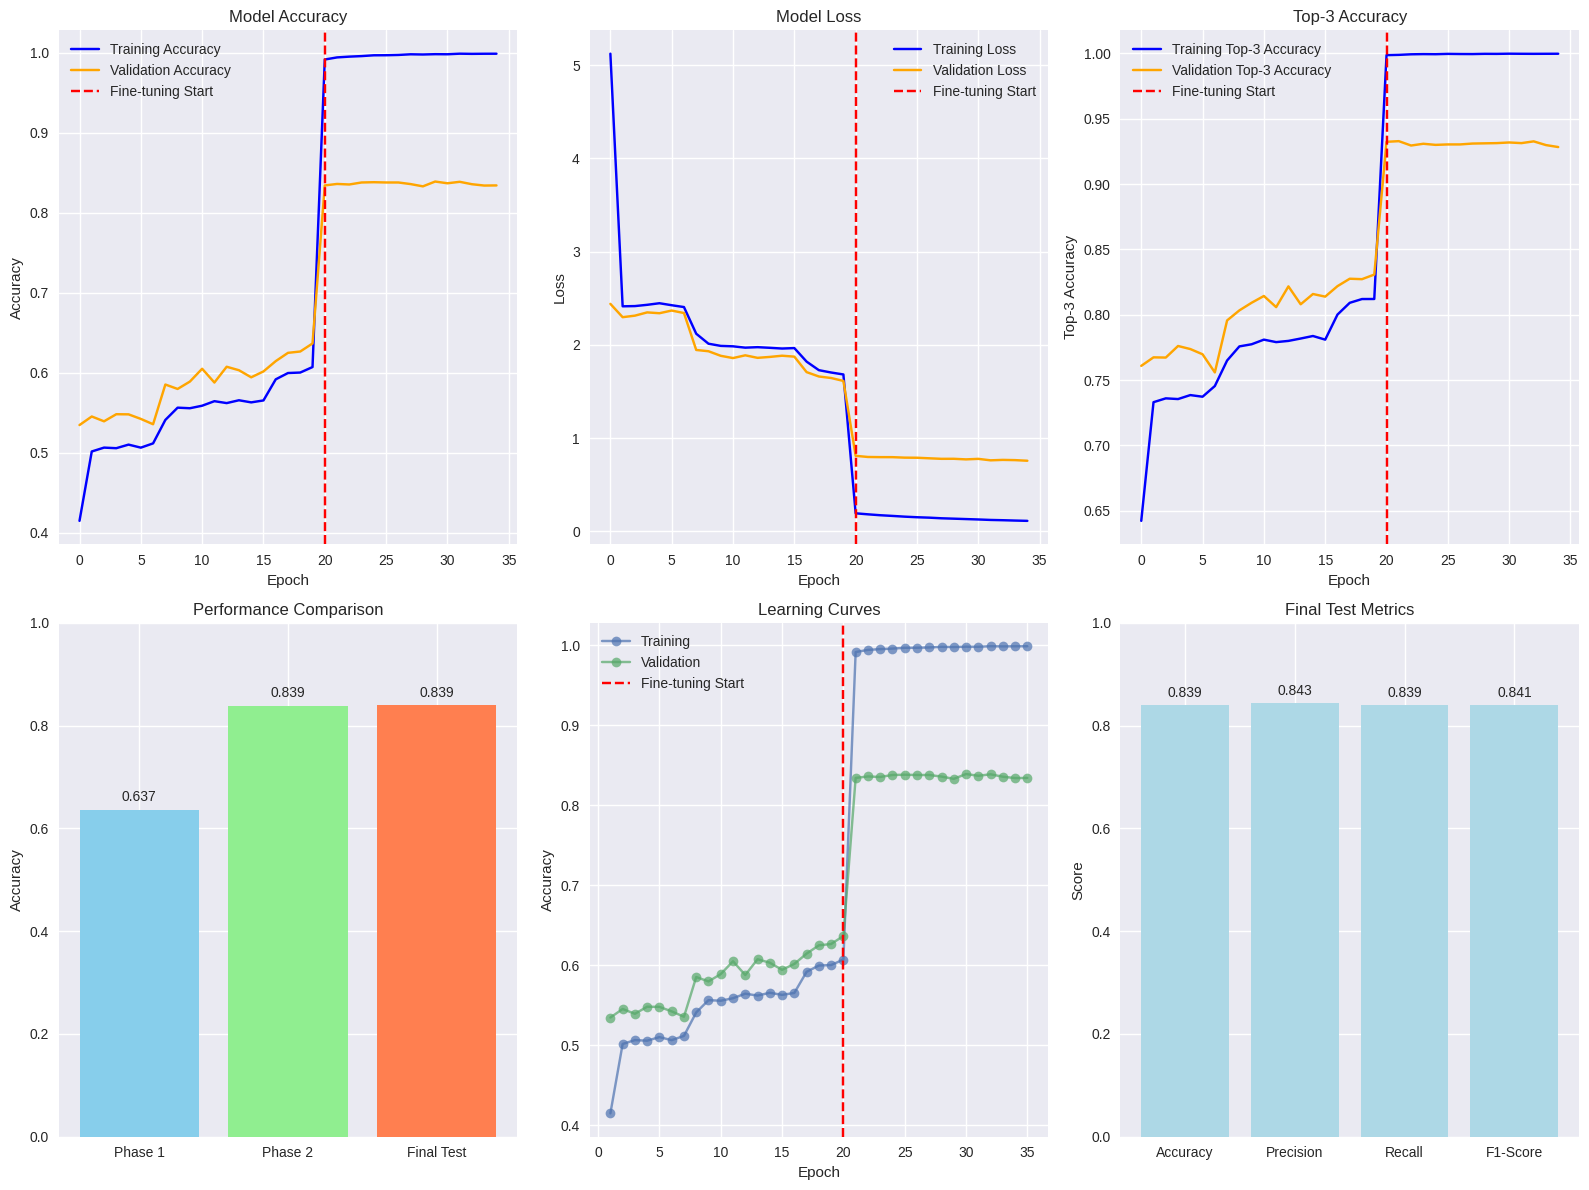

Training history saved to: ./output/training_history.csv

Training Summary:
Total training epochs: 35
Best validation accuracy: 0.8389
Final test accuracy: 0.8394
Best validation loss: 0.7576
Final test loss: 0.7366
Training summary saved to: ./output/training_summary.csv

Model Performance Insights:
Best performing classes: email, file_folder, handwritten
Worst performing classes: presentation, form, scientific_report
Average per-class accuracy: 0.8399
Standard deviation: 0.0765


In [24]:
# Combine training histories for comprehensive analysis
def combine_training_histories(history1, history2):
    """Combine two training histories."""
    combined_history = {}
    
    for key in history1.history.keys():
        if key in history2.history:
            combined_history[key] = history1.history[key] + history2.history[key]
        else:
            combined_history[key] = history1.history[key]
    
    return combined_history

# Combine both phases
if 'history_phase1' in locals() and 'history_phase2' in locals():
    combined_history = combine_training_histories(history_phase1, history_phase2)
    
    # Plot combined training history
    plt.figure(figsize=(16, 12))
    
    # Training and validation accuracy
    plt.subplot(2, 3, 1)
    plt.plot(combined_history['accuracy'], label='Training Accuracy', color='blue')
    plt.plot(combined_history['val_accuracy'], label='Validation Accuracy', color='orange')
    plt.axvline(x=len(history_phase1.history['accuracy']), color='red', linestyle='--', 
                label='Fine-tuning Start')
    plt.title('Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)
    
    # Training and validation loss
    plt.subplot(2, 3, 2)
    plt.plot(combined_history['loss'], label='Training Loss', color='blue')
    plt.plot(combined_history['val_loss'], label='Validation Loss', color='orange')
    plt.axvline(x=len(history_phase1.history['loss']), color='red', linestyle='--', 
                label='Fine-tuning Start')
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    
    # Top-3 accuracy
    plt.subplot(2, 3, 3)
    if 'top_3_accuracy' in combined_history:
        plt.plot(combined_history['top_3_accuracy'], label='Training Top-3 Accuracy', color='blue')
        plt.plot(combined_history['val_top_3_accuracy'], label='Validation Top-3 Accuracy', color='orange')
        plt.axvline(x=len(history_phase1.history['top_3_accuracy']), color='red', linestyle='--', 
                    label='Fine-tuning Start')
        plt.title('Top-3 Accuracy')
        plt.xlabel('Epoch')
        plt.ylabel('Top-3 Accuracy')
        plt.legend()
        plt.grid(True)
    else:
        plt.text(0.5, 0.5, 'Top-3 Accuracy\nNot Available', ha='center', va='center', transform=plt.gca().transAxes)
        plt.title('Top-3 Accuracy')
    
    # Performance comparison
    plt.subplot(2, 3, 4)
    phases = ['Phase 1', 'Phase 2', 'Final Test']
    accuracies = [
        max(history_phase1.history['val_accuracy']),
        max(history_phase2.history['val_accuracy']),
        accuracy
    ]
    bars = plt.bar(phases, accuracies, color=['skyblue', 'lightgreen', 'coral'])
    plt.title('Performance Comparison')
    plt.ylabel('Accuracy')
    plt.ylim(0, 1)
    for bar, acc in zip(bars, accuracies):
        plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01, 
                f'{acc:.3f}', ha='center', va='bottom')
    
    # Learning curves
    plt.subplot(2, 3, 5)
    train_sizes = np.arange(1, len(combined_history['accuracy']) + 1)
    plt.plot(train_sizes, combined_history['accuracy'], 'o-', label='Training', alpha=0.7)
    plt.plot(train_sizes, combined_history['val_accuracy'], 'o-', label='Validation', alpha=0.7)
    plt.axvline(x=len(history_phase1.history['accuracy']), color='red', linestyle='--', 
                label='Fine-tuning Start')
    plt.title('Learning Curves')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)
    
    # Final metrics summary
    plt.subplot(2, 3, 6)
    metrics = ['Accuracy', 'Precision', 'Recall', 'F1-Score']
    values = [accuracy, precision, recall, f1]
    bars = plt.bar(metrics, values, color='lightblue')
    plt.title('Final Test Metrics')
    plt.ylabel('Score')
    plt.ylim(0, 1)
    for bar, val in zip(bars, values):
        plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01, 
                f'{val:.3f}', ha='center', va='bottom')
    
    plt.tight_layout()
    plt.savefig('./output/comprehensive_analysis.png', dpi=150, bbox_inches='tight')
    plt.show()
    
    # Save training history data
    import pandas as pd
    history_df = pd.DataFrame(combined_history)
    history_df.to_csv('./output/training_history.csv', index=False)
    print("Training history saved to: ./output/training_history.csv")
    
    # Summary statistics
    print("\nTraining Summary:")
    print("=" * 50)
    print(f"Total training epochs: {len(combined_history['accuracy'])}")
    print(f"Best validation accuracy: {max(combined_history['val_accuracy']):.4f}")
    print(f"Final test accuracy: {accuracy:.4f}")
    print(f"Best validation loss: {min(combined_history['val_loss']):.4f}")
    print(f"Final test loss: {test_results[0]:.4f}")
    
    # Save summary statistics
    summary_stats = {
        'Total Epochs': len(combined_history['accuracy']),
        'Best Validation Accuracy': max(combined_history['val_accuracy']),
        'Final Test Accuracy': accuracy,
        'Best Validation Loss': min(combined_history['val_loss']),
        'Final Test Loss': test_results[0],
        'Test Precision': precision,
        'Test Recall': recall,
        'Test F1-Score': f1
    }
    
    summary_df = pd.DataFrame(list(summary_stats.items()), columns=['Metric', 'Value'])
    summary_df.to_csv('./output/training_summary.csv', index=False)
    print("Training summary saved to: ./output/training_summary.csv")
    
    # Model performance insights
    print("\nModel Performance Insights:")
    print("=" * 50)
    best_classes = accuracy_df.head(3)
    worst_classes = accuracy_df.tail(3)
    print(f"Best performing classes: {', '.join(best_classes['Class'].values)}")
    print(f"Worst performing classes: {', '.join(worst_classes['Class'].values)}")
    print(f"Average per-class accuracy: {accuracy_df['Accuracy'].mean():.4f}")
    print(f"Standard deviation: {accuracy_df['Accuracy'].std():.4f}")
    
else:
    print("Training histories not found. Please run the training cells first.")

Model saved successfully!
Model architecture saved!
Label encoder saved!

Testing prediction on random test images:

Image 1: 26857.jpg
True label: file_folder
Predicted: file_folder (confidence: 0.998)
Top 3 predictions: [(np.str_('file_folder'), np.float32(0.99847025)), (np.str_('presentation'), np.float32(0.00043069333)), (np.str_('advertisement'), np.float32(0.00020473351))]

Image 2: 30113.jpg
True label: news_article
Predicted: news_article (confidence: 0.885)
Top 3 predictions: [(np.str_('news_article'), np.float32(0.88464963)), (np.str_('scientific_publication'), np.float32(0.1068621)), (np.str_('advertisement'), np.float32(0.0024311014))]

Image 3: 9689.jpg
True label: presentation
Predicted: presentation (confidence: 0.666)
Top 3 predictions: [(np.str_('presentation'), np.float32(0.6659519)), (np.str_('resume'), np.float32(0.304786)), (np.str_('scientific_report'), np.float32(0.010130222))]

Image 4: 27846.jpg
True label: budget
Predicted: budget (confidence: 0.986)
Top 3 pre

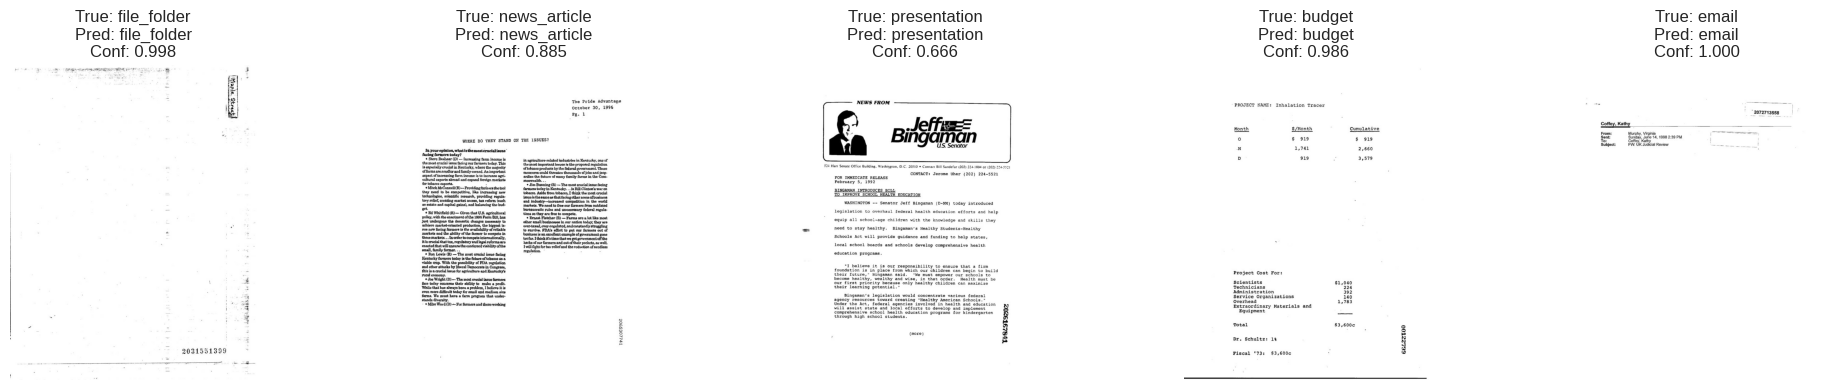


Prediction pipeline ready!
Use predict_document_class(image_path) to classify new documents.


In [20]:
# Save the final model
model.save('./output/vgg16_document_classifier.h5')
print("Model saved successfully!")

# Save model architecture as JSON
model_json = model.to_json()
with open('./output/vgg16_architecture.json', 'w') as json_file:
    json_file.write(model_json)
print("Model architecture saved!")

# Save label encoder
import pickle
with open('./output/label_encoder.pkl', 'wb') as f:
    pickle.dump(label_encoder, f)
print("Label encoder saved!")

# Function to predict single image
def predict_single_image(model, image_path, label_encoder):
    """
    Predict the class of a single image.
    """
    try:
        # Preprocess image
        img = preprocess_image(image_path)
        img_batch = np.expand_dims(img, axis=0)
        img_batch = tf.keras.applications.vgg16.preprocess_input(img_batch * 255.0)
        
        # Get prediction
        prediction = model.predict(img_batch, verbose=0)
        predicted_class_idx = np.argmax(prediction)
        predicted_class = label_encoder.classes_[predicted_class_idx]
        confidence = prediction[0][predicted_class_idx]
        
        # Get top 3 predictions
        top_3_indices = np.argsort(prediction[0])[-3:][::-1]
        top_3_predictions = [(label_encoder.classes_[idx], prediction[0][idx]) 
                            for idx in top_3_indices]
        
        return predicted_class, confidence, top_3_predictions
    
    except Exception as e:
        print(f"Error predicting image {image_path}: {e}")
        return None, None, None

# Test prediction on a few random test images
print("\nTesting prediction on random test images:")
print("=" * 50)

n_examples = 5
random_indices = np.random.choice(len(X_test), n_examples, replace=False)

plt.figure(figsize=(20, 4))
for i, idx in enumerate(random_indices):
    img_path = X_test[idx]
    true_label = y_test[idx]
    
    # Make prediction
    pred_class, confidence, top_3 = predict_single_image(model, img_path, label_encoder)
    
    # Load and display image
    img = Image.open(img_path)
    plt.subplot(1, n_examples, i+1)
    plt.imshow(img, cmap='gray')
    plt.title(f'True: {true_label}\nPred: {pred_class}\nConf: {confidence:.3f}')
    plt.axis('off')
    
    # Print detailed prediction
    print(f"\nImage {i+1}: {img_path.name}")
    print(f"True label: {true_label}")
    print(f"Predicted: {pred_class} (confidence: {confidence:.3f})")
    print(f"Top 3 predictions: {top_3}")

plt.tight_layout()
plt.savefig('./output/prediction_examples.png', dpi=150, bbox_inches='tight')
plt.show()

# Create a prediction function for new images
def predict_document_class(image_path, model_path=None):
    """
    Complete prediction pipeline for new document images.
    """
    if model_path:
        # Load model if path provided
        loaded_model = tf.keras.models.load_model(model_path)
        # Load label encoder
        with open('./output/label_encoder.pkl', 'rb') as f:
            loaded_label_encoder = pickle.load(f)
    else:
        loaded_model = model
        loaded_label_encoder = label_encoder
    
    return predict_single_image(loaded_model, image_path, loaded_label_encoder)

print("\nPrediction pipeline ready!")
print("Use predict_document_class(image_path) to classify new documents.")